In [2]:
import pandas as pd

In [3]:
df_hsk = pd.concat(
    (
        pd.read_csv(f"data/hsk{i}.csv", names=["simplified", "pinyin", "meanings"])
        .assign(level=i)
    )
    for i in range(1,7)
)[["simplified", "pinyin", "meanings", "level"]]

In [46]:
def vowelsToTone(pinyin):
    accentMap = {
        "a": ["ā", "á", "ǎ", "à"],  #, "a"],
        "A": ["Ā", "Á", "Ǎ", "À"],  #, "A"],
        "e": ["ē", "é", "ě", "è"],  #, "e"],
        "E": ["Ē", "É", "Ě", "È"],  #, "E"],
        "i": ["ī", "í", "ǐ", "ì"],  #, "i"],
        "I": ["Ī", "Í", "Ǐ", "Ì"],  #, "I"],
        "o": ["ō", "ó", "ǒ", "ò"],  #, "o"],
        "O": ["Ō", "Ó", "Ǒ", "Ò"],  #, "o"],
        "u": ["ū", "ú", "ǔ", "ù"],  #, "u"],
        "U": ["Ū", "Ú", "Ǔ", "Ù"],  #, "u"],
        "v": ["ǖ", "ǘ", "ǚ", "ǜ"],  #, "ü"],
        "V": ["Ǖ", "Ǘ", "Ǚ", "Ǜ"],  #, "Ü"],
    }
    def vowelToTone(word):
        for noAccent, accents in accentMap.items():
            for i, accent in enumerate(accents):
                if accent in word:
                    return f"{word.replace(accent, noAccent)}{i+1}"
        return f"{word}5"
        
    return " ".join(vowelToTone(x) for x in pinyin.split(" "))

df_hsk = df_hsk.assign(pinyin=df_hsk["pinyin"].map(vowelsToTone))
df_hsk

,simplified,pinyin,meanings,level
0,爱,ai45,to love,1
1,八,ba15,eight,1
2,爸爸,ba45 ba55,(informal) father,1
3,杯子,bei15 zi55,cup,1
4,北京,Bei35 jing15,Beijing,1
...,...,...,...,...
2495,座右铭,zuo45 you45 ming25,motto,6
2496,作弊,zuo45 bi45,to practice fraud,6
2497,作废,zuo45 fei45,to become invalid,6
2498,作风,zuo45 feng15,style,6


In [105]:
# https://github.com/mike-fabian/ibus-table-chinese/blob/main/tables/
df_cj = pd.read_csv(
#     "data/cangjie5.txt",
    "data/cangjie-big.txt",
    comment="#",
    sep="\t",
    quoting=3,  # csv.QUOTE_NONE
#     skiprows=148,
    skiprows=160,
    skipfooter=2,
    keep_default_na=False,
    names=["cangjie", "hanzi", "noidea"],
)[["hanzi", "cangjie"]]

df_cj = (
    df_cj
    .assign(
        hanzi=df_cj["hanzi"].astype("string"),
        cangjie=df_cj["cangjie"].astype("string")
    )
    .groupby("hanzi")
    .agg("first")  # first is fine because the only duplicates are weird symbols
)

/var/folders/q1/w0s_n4x93y30t1tf6m9x42rw0000gn/T/ipykernel_6569/3080385304.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df_cj = pd.read_csv(


In [108]:
df_wb = pd.read_csv(
    "data/wubi-haifeng86.UTF-8",
    comment="#",
    sep="\t",
    quoting=3,  # csv.QUOTE_NONE
    skiprows=0,
    skipfooter=0,
    keep_default_na=False,
    names=["wubi", "hanzi", "noidea"],
)[["hanzi", "wubi"]]

# not sure what len(hanzi)>1 means when it has a full stop, but just remove
df_wb = df_wb[df_wb["hanzi"].map(len).eq(1)]#.groupby("hanzi").agg({"wubi": lambda x: " ".join(x)})
df_wb = (
    df_wb
    .assign(
        hanzi=df_wb["hanzi"].astype("string"),
        wubi=df_wb["wubi"].astype("string")
    )
    .groupby("hanzi")
    # there are many ways to type the same zi but choose the shortest one for our purposes
    .agg(lambda x: min(sorted(x), key=len))
)

In [205]:
hsk_levels = {1,2,3}
# df_hsk["simplified"].str.split("")
zi_set = set(''.join(df_hsk[df_hsk["level"].isin(hsk_levels)]["simplified"]))
len(zi_set)

618

In [116]:
df_hier = df_cj[df_cj.index.isin(zi_set)].join(df_wb, how="inner")

assert len(df_hier) == len(zi_set)
assert sum(df_hier["cangjie"].str.contains(" ")) == 0
assert sum(df_hier["wubi"].str.contains(" ")) == 0

df_hier

,cangjie,wubi
hanzi,,
一,m,g
七,jv,ag
万,ms,dnv
丈,jk,dyi
三,mmm,dg
...,...,...
鸟,hsim,qyng
鸡,ehsm,cqy
黄,twc,amw


hierarchy needs a placement for leaves and branches
for cangjie we can just use alphabetical order for positioning nodes
                 abcdefghijklmnopqrstuvwxyz
for wubi we want gfdsahjklmtrewqyuiopnbvcxz

but what about when there is a ab abc, where a and b are both branch and leaf?
I think the cleanest is something like:
     a
    / \
   .   b
   |  / \
   . .   c

this keeps the layout planar
if there is a long line of single children then we can consider only keeping the first single parent with the leaf
I don't think we have enough layers for this to be a big issue though

In [178]:
import networkx as nx
import math
import functools

In [211]:
def trie_from_spellings(spellings: pd.Series):
    dg = nx.DiGraph()
    root = dg.add_node("")
    
    padded = spellings.str.pad(spellings.map(len).max(), "right")
    for zi, spelling in padded.items():
        dg.add_edge("", spelling[0])
        for i in range(len(spelling) - 1):
            dg.add_edge(spelling[:i+1], spelling[:i+2])
        dg.add_edge(spelling, zi)
    
    return dg

def add_ci_to_trie(dg: nx.DiGraph, )

In [212]:
trie = trie_from_spellings(df_hier["cangjie"])
assert nx.is_arborescence(trie)
trie.graph["num_leaves"] = len(df_hier)

In [187]:
def radial_layout(trie: nx.DiGraph, parent: str, depth: int, leaf_i: int) -> (int, float, float):
    children = sorted(x[1] for x in trie.edges(parent))
    if not children:
        angle = 2*math.pi * leaf_i / trie.graph["num_leaves"]
        trie.nodes[parent]["angle"] = angle
        trie.nodes[parent]["depth"] = depth
        return leaf_i + 1, angle, angle
    
    leaf_i, min_angle, max_angle = radial_layout(trie, children[0], depth+1, leaf_i)
    for i in range(1, len(children)):
        leaf_i, _, max_angle = radial_layout(trie, children[i], depth+1, leaf_i)
        
    trie.nodes[parent]["angle"] = (min_angle + max_angle) / 2
    trie.nodes[parent]["depth"] = depth
    return leaf_i, min_angle, max_angle

In [192]:
radial_layout(trie, "", 0, 0)

(618, 0.0, 6.273018340663114)

In [193]:
import matplotlib.pyplot as plt

(-6.6, 6.6, -6.599914722236923, 6.599914722236923)

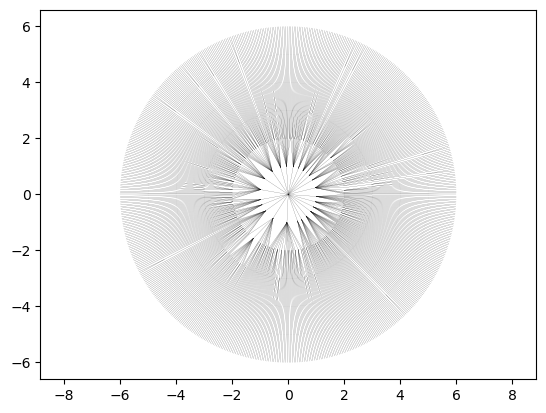

In [201]:
fig, ax = plt.subplots()

for source, target in trie.edges:
    x0 = trie.nodes[source]["depth"] * math.cos(trie.nodes[source]["angle"])
    y0 = trie.nodes[source]["depth"] * math.sin(trie.nodes[source]["angle"])
    x1 = trie.nodes[target]["depth"] * math.cos(trie.nodes[target]["angle"])
    y1 = trie.nodes[target]["depth"] * math.sin(trie.nodes[target]["angle"])
    ax.plot([x0,x1], [-y0,-y1], color='k', linewidth=0.1)

ax.axis('equal')

In [202]:
df_hier["cangjie"].map(len).value_counts()

4    224
3    196
2     96
5     88
1     14
Name: cangjie, dtype: int64